In [281]:
import numpy as np
import scipy.io as io

import keras
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Flatten
import keras.backend as K
from keras.constraints import max_norm
from keras.regularizers import l1_l2
from keras.layers.core import Dense, Activation, Dropout, Permute, Reshape
from keras.callbacks import Callback, EarlyStopping

In [171]:
K.set_image_data_format('channels_first')

def square(x):
    return K.square(x)

def log(x):
    return K.log(K.clip(x, min_value = 1e-7, max_value = 10000))   

def safe_log(x):
    return K.log(x + 1e-7)

def process_data(train, label, n_class, day_index=1, subject_index=1, shuffle=True):
    train = np.squeeze(train[:,:,np.where(label[:,1]==day_index)])
    train = np.transpose(train, axes=[2,0,1])
    train = train.reshape(train.shape[0], 1, train.shape[1], train.shape[2])
    
    label = np.squeeze(label[np.where(label[:,1]==day_index),0])   
    if n_class == 2:
        label[np.where(label != subject_index)] = subject_index + 1
        label = keras.utils.to_categorical(label-subject_index, n_class)
    else:
        label = keras.utils.to_categorical(label-1, n_class)
        
    if shuffle:
        permutation = np.random.permutation(train.shape[0])
        train = train[permutation,:,:]
        label = label[permutation,:]
        
    return train, label 

In [172]:
datapath = '/Users/dustintt123/SSVEP_CNN/SSVEP_Data/'
SSVEP_l = io.loadmat(datapath+'SSVEP_l.mat')['SSVEP_l']
SSVEP_h = io.loadmat(datapath+'SSVEP_h.mat')['SSVEP_h']
SSVEP_label = io.loadmat(datapath+'SSVEP_label.mat')['label'] # i_subj, i_session, i_stim, i_trial

# binary one-vs-all classification
n_class = 2
subject = 8
train_day = 1

x_train, y_train = process_data(SSVEP_l, SSVEP_label, n_class=n_class, day_index=train_day, subject_index=subject)
x_test, y_test = process_data(SSVEP_l, SSVEP_label, n_class=n_class, day_index=train_day+1, subject_index=subject)

n_trial, n_height, n_channel, n_timestamp = x_train.shape

    Keras implementation of the Shallow Convolutional Network as described
    in Schirrmeister et. al. (2017), arXiv 1703.0505
    
    Assumes the input is a 2-second EEG signal sampled at 128Hz. Note that in 
    the original paper, they do temporal convolutions of length 25 for EEG
    data sampled at 250Hz. We instead use length 13 since the sampling rate is 
    roughly half of the 250Hz which the paper used. The pool_size and stride
    in later layers is also approximately half of what is used in the paper.
    
                     ours        original paper
    pool_size        1, 35       1, 75
    strides          1, 7        1, 15
    conv filters     1, 13       1, 25

In [305]:
def ShallowConvNet(input_shape, conv1_size=(1, 25), conv2_size=(9, 1), conv1_filter=10, conv2_filter=10):
    dropout_rate = 0.5
    
    # start the model
    input_EEG = Input(input_shape)
    if conv1_size = (1, 1):
        block1       = Conv2D(conv2_filter, conv2_size, use_bias=True, kernel_constraint = max_norm(2.))(input_EEG)
    else:
        block1       = Conv2D(conv1_filter, conv1_size, kernel_constraint = max_norm(2.))(input_EEG)
        block1       = Conv2D(conv2_filter, conv2_size, use_bias=True, kernel_constraint = max_norm(2.))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation(square)(block1)
    block1       = AveragePooling2D(pool_size=(1, 30), strides=(1, 10))(block1)
    block1       = Activation(safe_log)(block1)
    block1       = Dropout(dropout_rate)(block1)
    flatten      = Flatten()(block1)
    dense        = Dense(n_class, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_EEG, outputs=softmax)

class AccLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
    def on_epoch_end(self, batch, logs={}):
        self.acc.append([logs.get('acc'), logs.get('val_acc')])
        self.loss.append([logs.get('loss'), logs.get('val_loss')])

SyntaxError: invalid syntax (<ipython-input-305-e9740e09603d>, line 6)

In [306]:
batch_size = 100
n_epoch = 100
isEarlyStopping = True
n_patience = 10
conv1_size_list = [(1, 1), (1, 7), (1,13)]
conv2_size_list = [(n_channel, 25)]
conv1_filter_list = [5, 10, 20]
conv2_filter_list = [5, 10, 20]

history_list4 = []
score_list4 = []

for i, conv1_size in enumerate(conv1_size_list):
    history_list4.append([])
    score_list4.append([])
    for j, conv2_size in enumerate(conv2_size_list):   
        # Setup model
        model = ShallowConvNet(x_train.shape[1:], conv1_size, conv2_size, 5, 10)
        model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.adam(),
                  metrics=['accuracy'])

        # Setup callbacks
        history = AccLossHistory()

        if isEarlyStopping:
            earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=n_patience, verbose=1, mode='auto')
            callbacks = [history, earlyStopping]
        else:
            callbacks = [history]

        # Model fit
        fit_hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=n_epoch,
              verbose=1,
              validation_split=0.25,
              callbacks=callbacks,
              shuffle=True)

        # Record metrics
        history_list4[i].append(history)
        y_hat = model.predict_on_batch(x_test)
        score = model.evaluate(x_test, y_test, verbose = 1)
        score_list4[i].append(score)
        
        print(model.metrics_names[0], ': ', score[0])
        print(model.metrics_names[1], ': ', score[1])


Train on 1440 samples, validate on 480 samples
Epoch 1/100
1440/1440 [==============================] - 13s 9ms/step - loss: 0.6647 - acc: 0.6986 - val_loss: 0.4296 - val_acc: 0.8146
Epoch 2/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.4390 - acc: 0.8160 - val_loss: 0.3465 - val_acc: 0.8437
Epoch 3/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.3516 - acc: 0.8583 - val_loss: 0.3390 - val_acc: 0.8562
Epoch 4/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.3368 - acc: 0.8583 - val_loss: 0.2855 - val_acc: 0.8708
Epoch 5/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.2708 - acc: 0.8924 - val_loss: 0.3353 - val_acc: 0.8500
Epoch 6/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.2793 - acc: 0.8944 - val_loss: 0.2548 - val_acc: 0.8875
Epoch 7/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.2365 - acc: 0.8979 - val_loss: 0.3347 - val_acc: 0.8437
Epoch 8

Epoch 26/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.1040 - acc: 0.9597 - val_loss: 0.1370 - val_acc: 0.9542
Epoch 27/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0998 - acc: 0.9632 - val_loss: 0.1292 - val_acc: 0.9500
Epoch 28/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.1062 - acc: 0.9639 - val_loss: 0.1614 - val_acc: 0.9417
Epoch 29/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.1197 - acc: 0.9535 - val_loss: 0.1037 - val_acc: 0.9583
Epoch 30/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0917 - acc: 0.9653 - val_loss: 0.0900 - val_acc: 0.9646
Epoch 31/100
1440/1440 [==============================] - 5s 4ms/step - loss: 0.0833 - acc: 0.9701 - val_loss: 0.0893 - val_acc: 0.9604
Epoch 32/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0782 - acc: 0.9722 - val_loss: 0.0943 - val_acc: 0.9729
Epoch 33/100
1440/1440 [========================

Epoch 40/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0492 - acc: 0.9861 - val_loss: 0.0412 - val_acc: 0.9875
Epoch 41/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0372 - acc: 0.9910 - val_loss: 0.0481 - val_acc: 0.9854
Epoch 42/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0549 - acc: 0.9826 - val_loss: 0.0550 - val_acc: 0.9792
Epoch 43/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0363 - acc: 0.9896 - val_loss: 0.0585 - val_acc: 0.9813
Epoch 44/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0336 - acc: 0.9910 - val_loss: 0.0342 - val_acc: 0.9938
Epoch 45/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0313 - acc: 0.9938 - val_loss: 0.0303 - val_acc: 0.9938
Epoch 46/100
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0273 - acc: 0.9903 - val_loss: 0.0300 - val_acc: 0.9917
Epoch 47/100
1440/1440 [========================

In [307]:
x4 = len(conv1_size_list)
y4 = len(conv2_size_list)
test_acc4 = np.empty((x4, y4))
test_loss4 = np.empty((x4, y4))
val_acc4 = np.empty((x4, y4))
val_loss4 = np.empty((x4, y4))

for i in range(x4):
    for j in range(y4):
        test_acc4[i][j] = score_list4[i][j][-1]
        test_loss4[i][j] = score_list4[i][j][0]
        val_acc4[i][j] = history_list4[i][j].acc[-1][-1]
        val_loss4[i][j] = history_list4[i][j].loss[-1][0]
        
scores4 = np.array(score_list4)
histories4 = np.array(history_list4)


In [308]:
import os
docs_dir=os.path.expanduser('~/SSVEP_CNN/Results')
np.save(os.path.join(docs_dir, 'ConvSize_3x1_test_acc'), test_acc4)
np.save(os.path.join(docs_dir, 'ConvSize_3x1_val_acc'), val_acc4)
np.save(os.path.join(docs_dir, 'ConvSize_3x1_val_loss'), val_loss4)

In [309]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [310]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

Text(0.5,0,'Conv2 Size')

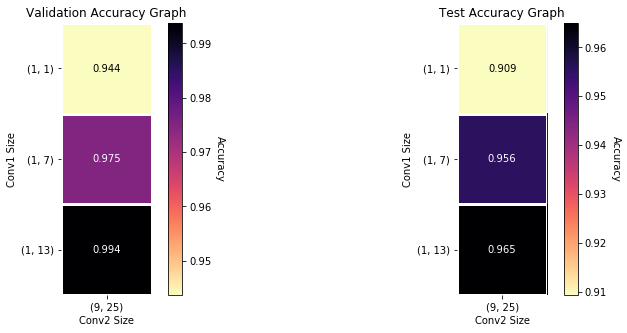

In [311]:
'''PLOTING MODULE'''
fig = plt.figure(figsize=(13,5))

val_plot = fig.add_subplot(121)
# val_plot.imshow(val_acc, interpolation='nearest')
# plt.legend(loc=4, borderaxespad=0.7)
# plt.title('Validation Accuracy Graph')
# plt.ylabel('Conv1 Size')
# plt.xlabel('Conv2 Size')
# plt.yticks(range(len(conv1_size_list)), conv1_size_list)
# plt.xticks(range(len(conv2_size_list)), conv2_size_list)

val_im, cbar = heatmap(val_acc4, conv1_size_list, conv2_size_list, ax=val_plot,
                   cmap='magma_r', cbarlabel="Accuracy")
texts = annotate_heatmap(val_im, valfmt="{x:.3f}")

plt.title('Validation Accuracy Graph')
plt.ylabel('Conv1 Size')
plt.xlabel('Conv2 Size')

test_plot = fig.add_subplot(122)
# test_plot.imshow(test_acc, interpolation='nearest')
# # plt.legend(loc=1, borderaxespad=0.7)
# plt.title('Test Accuracy Graph')
# plt.ylabel('Conv1 Size')
# plt.xlabel('Conv2 Size')
# plt.yticks(range(len(conv1_size_list)), conv1_size_list)
# plt.xticks(range(len(conv2_size_list)), conv2_size_list)

test_im, cbar = heatmap(test_acc4, conv1_size_list, conv2_size_list, ax=test_plot,
                   cmap='magma_r', cbarlabel="Accuracy")
texts = annotate_heatmap(test_im, valfmt="{x:.3f}")

plt.title('Test Accuracy Graph')
plt.ylabel('Conv1 Size')
plt.xlabel('Conv2 Size')

In [297]:
'''
So far, the best convolutional layer configuration is
Conv1: No. of filters = 5, Filter Size = (1, 25)
Conv2: No. of filters = 10, Filter Size = (9, 1)
'''

'\nSo far, the best convolutional layer configuration is\nConv1: No. of filters = 5, Filter Size = (1, 25)\nConv2: No. of filters = 10, Filter Size = (9, 1)\n'

AttributeError: 'list' object has no attribute 'acc'

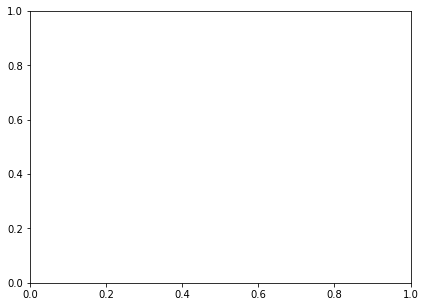

In [178]:
fig = plt.figure(figsize=(15,5))
acc_plot = fig.add_subplot(121)
for i in range(len(conv1_size_list)):
    his = history_list[i]
    acc_plot.plot(np.array(his.acc)[:,1], label='Conv1 Size {}'.format(conv1_size_list[i]))
plt.legend(loc=4, borderaxespad=0.7)
plt.title('Validation Accuracy Graph')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')

loss_plot = fig.add_subplot(122)
for i in range(len(conv1_size_list)):
    his = history_list[i]
    loss_plot.plot(np.array(his.loss)[:,1], label='Conv1 Size {}'.format(conv1_size_list[i]))
plt.legend(loc=1, borderaxespad=0.7)
plt.title('Validation Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')


In [ ]:
scores = np.array(score_list)
t = range(len(conv1_size_list))

fig, acc_axis = plt.subplots()

color = 'tab:red'
acc_axis.set_ylabel('Accuracy', color=color)
acc_axis.plot(t, scores[:,1], 'x--', color=color)
acc_axis.tick_params(axis='y', labelcolor=color)

loss_axis = acc_axis.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
loss_axis.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
loss_axis.plot(t, scores[:,0], 'o--', color=color)
loss_axis.tick_params(axis='y', labelcolor=color)

plt.title('Test Result')
plt.xlabel('Conv1 Size')
plt.xticks(t, conv1_size_list)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()